In [1]:
# import dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions
%matplotlib inline

In [2]:
# dataset link
url = "https://github.com/yakobodata/Athena_motor_insurance/raw/refs/heads/main/motor_insurance_dataset.csv"
# load the dataset into dataframe
df = pd.read_csv(url)

In [3]:
# load the first 5 rows
df.head()

,Premium Price,Conversion,Customer Age,Customer Gender,Location,Vehicle Make,Vehicle Age,Coverage Type,Claims History,Discounts Offered,Policy Duration,Customer Loyalty,Marketing Channel,Competitor Pricing,Sales Campaigns
0,1226,0.0,60,Other,Suburban,Chevrolet,17,Liability,0,303,12,0,Television,1281,4
1,960,0.0,46,Other,Urban,BMW,11,Comprehensive,2,161,12,7,Online,917,3
2,1394,0.0,67,Male,Urban,Honda,2,Third-Party,4,212,12,5,Social Media,1476,2
3,1230,0.0,19,Other,Rural,BMW,16,Third-Party,0,483,12,5,Social Media,1202,3
4,1195,0.0,26,Other,Urban,Chevrolet,13,Liability,1,91,6,9,Social Media,1382,2


In [4]:
# check if there is any missing values
df.isnull().sum()

Premium Price         0
Conversion            0
Customer Age          0
Customer Gender       0
Location              0
Vehicle Make          0
Vehicle Age           0
Coverage Type         0
Claims History        0
Discounts Offered     0
Policy Duration       0
Customer Loyalty      0
Marketing Channel     0
Competitor Pricing    0
Sales Campaigns       0
dtype: int64

In [5]:
# check if there is any duplicated rows
df.duplicated().sum()

0

In [6]:
# lets check stats
df.describe()

,Premium Price,Conversion,Customer Age,Vehicle Age,Claims History,Discounts Offered,Policy Duration,Customer Loyalty,Competitor Pricing,Sales Campaigns
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,809.731300,0.000300,43.402500,9.454800,1.996400,247.842300,9.003000,4.465900,808.858500,2.026200
std,402.867426,0.017319,15.051317,5.758721,1.411803,144.535318,3.000149,2.874589,418.856223,1.414749
min,100.000000,0.000000,18.000000,0.000000,0.000000,0.000000,6.000000,0.000000,-97.000000,0.000000
25%,465.000000,0.000000,31.000000,4.000000,1.000000,123.000000,6.000000,2.000000,458.000000,1.000000
50%,815.000000,0.000000,43.000000,9.000000,2.000000,245.000000,12.000000,4.000000,816.000000,2.000000
75%,1162.000000,0.000000,57.000000,14.000000,3.000000,373.000000,12.000000,7.000000,1153.000000,3.000000
max,1499.000000,1.000000,69.000000,19.000000,4.000000,499.000000,12.000000,9.000000,1695.000000,4.000000


# Exploratory Data Analysis

### Uni-Variate Analysis

- Categorical Columns

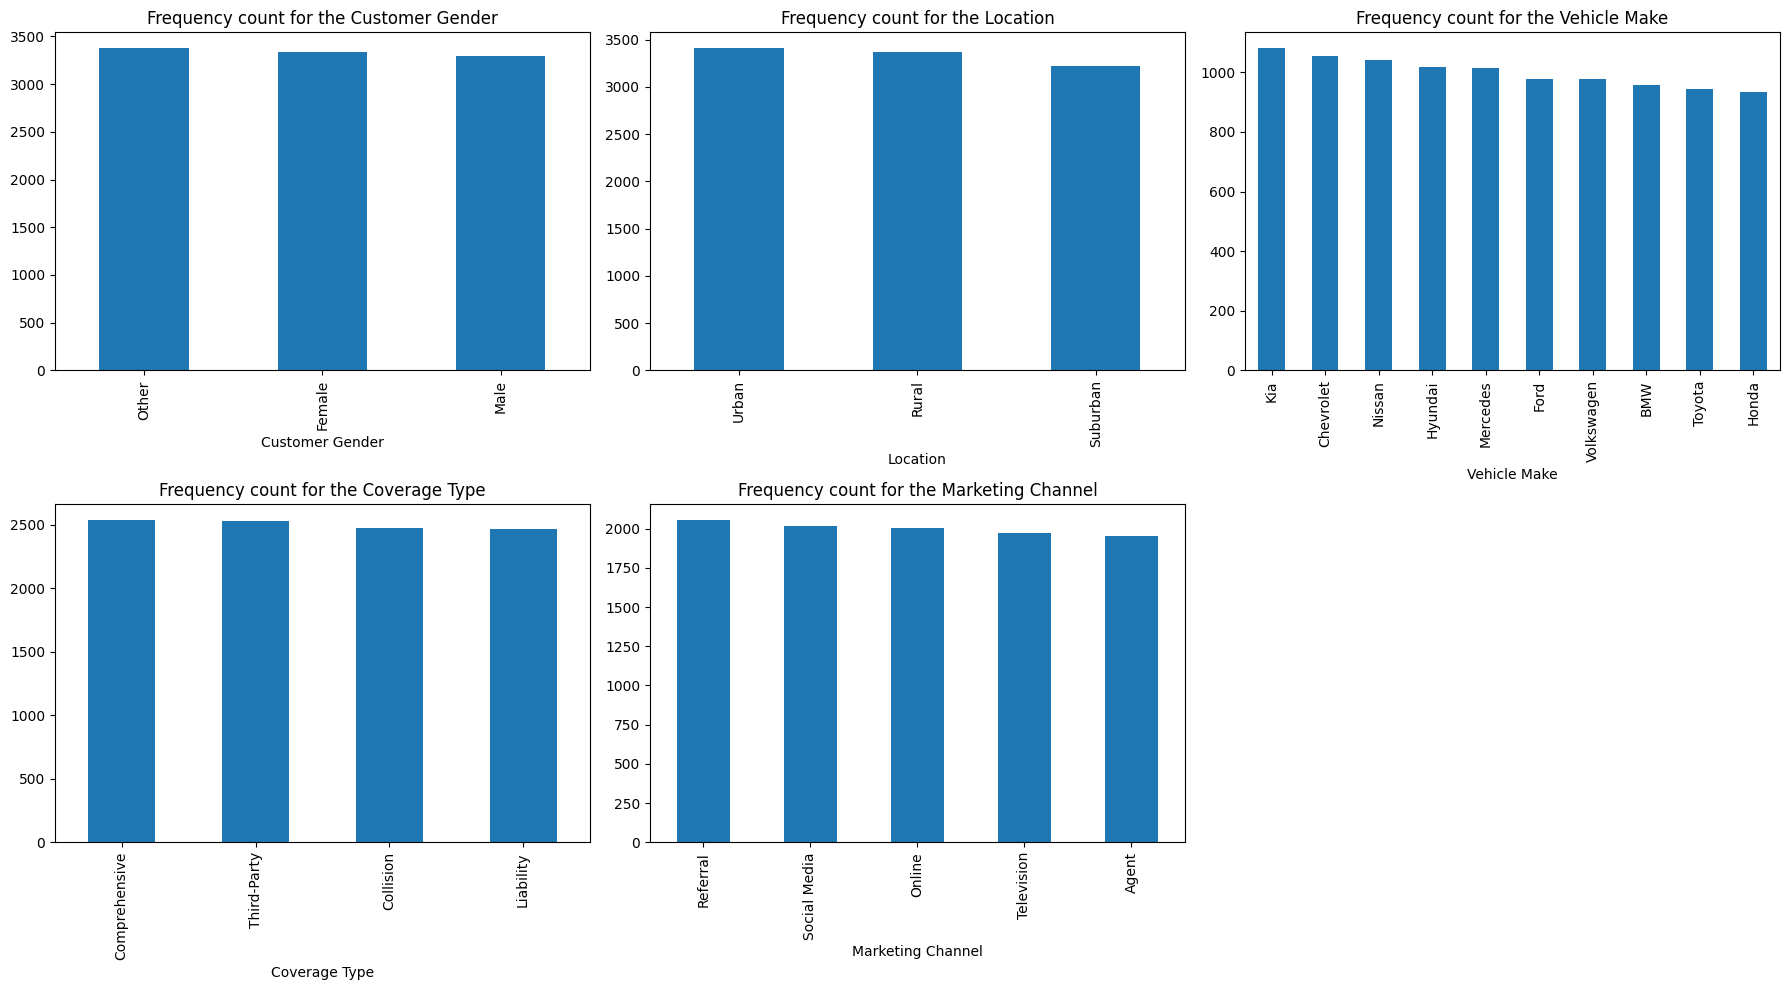

In [7]:
# lets make countplot for each categorical column
cat_cols = [col for col in df.columns if df[col].dtype == "object"]
# lets make subplot for the graphs
fig,ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))
ax = ax.flatten()

# loop over the columns 
for index, column in enumerate(cat_cols):
    # make a countplot
    df[column].value_counts(ascending=False).plot(kind="bar", ax=ax[index])
    ax[index].set_title(f"Frequency count for the {column}")
    

# delete the unused subplots
for i in range(len(cat_cols), len(ax)):
    fig.delaxes(ax[i])
    
plt.tight_layout()
plt.show()

- Numerical Columns

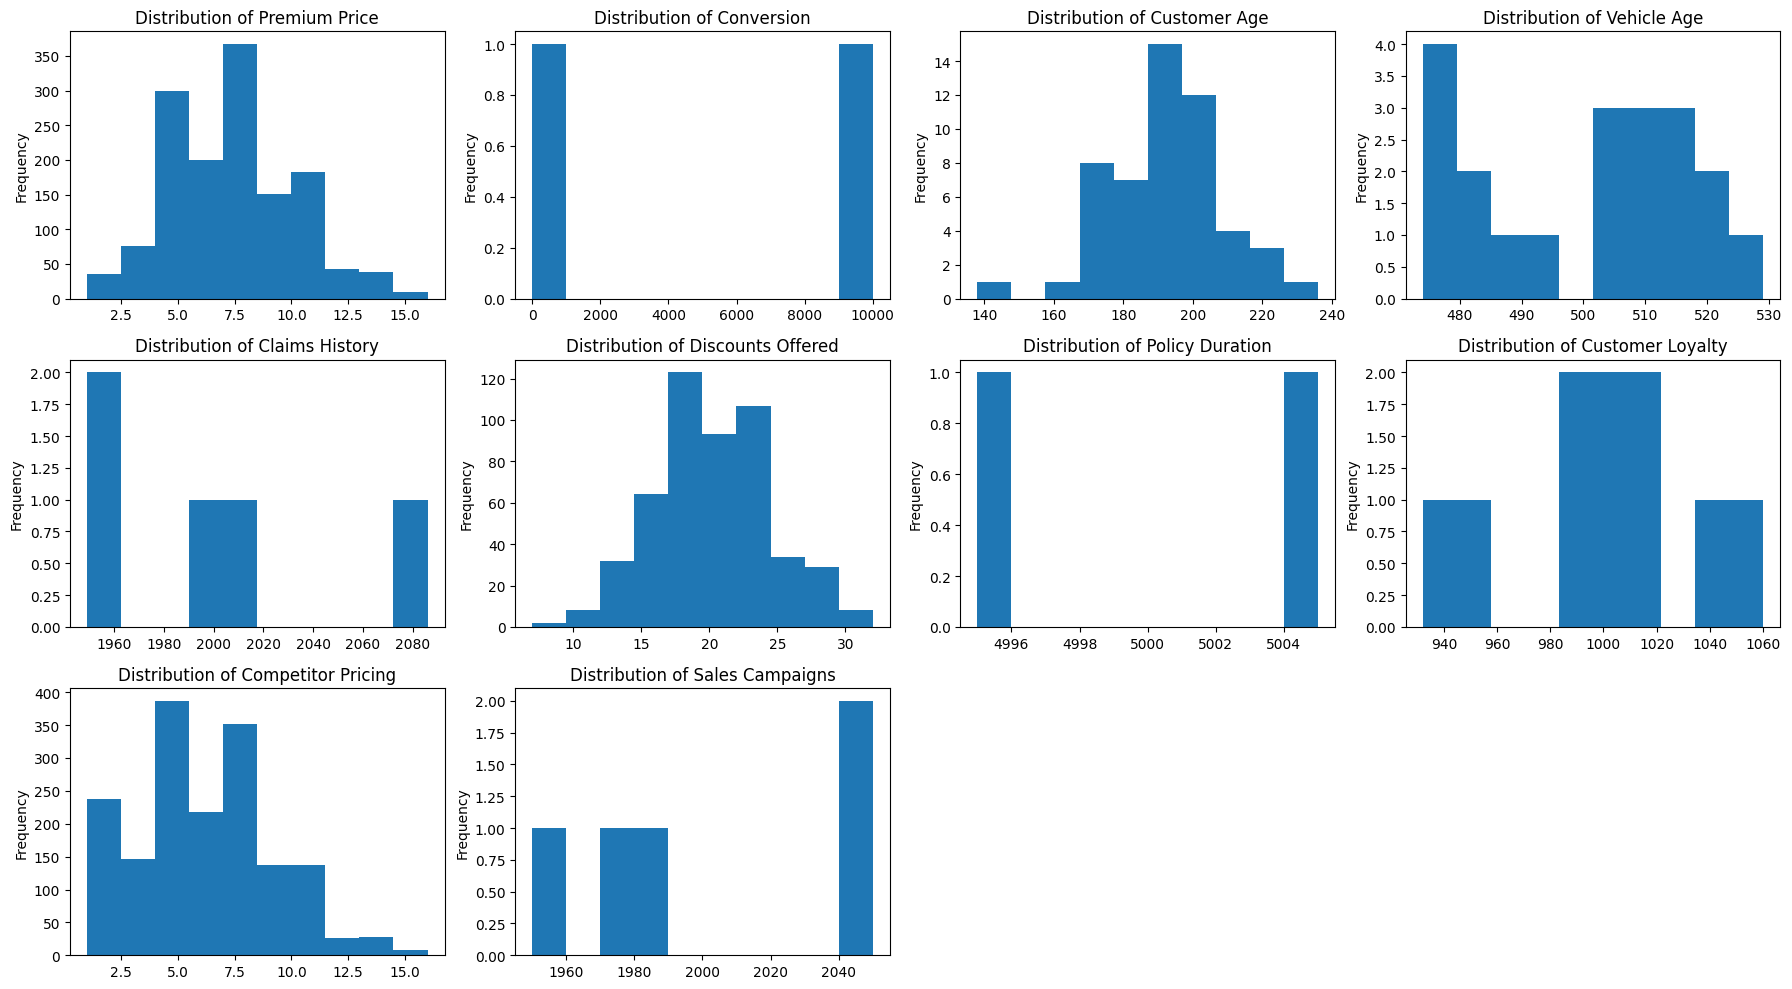

In [8]:
# lets make  histogram to see the distribution of features
# lets make countplot for each categorical column
num_cols = [col for col in df.columns if df[col].dtype != "object"]
# lets make subplot for the graphs
fig,ax = plt.subplots(ncols=4, nrows=3, figsize=(18, 10))
ax = ax.flatten()

# loop over the columns 
for index, column in enumerate(num_cols):
    # make a countplot
    df[column].value_counts(ascending=False).plot(kind="hist", ax=ax[index])
    ax[index].set_title(f"Distribution of {column}")
    

# delete the unused subplots
for i in range(len(num_cols), len(ax)):
    fig.delaxes(ax[i])
    
plt.tight_layout()
plt.show()

* It seems we have distributions normal, bernoulli, bimodal, and possion 

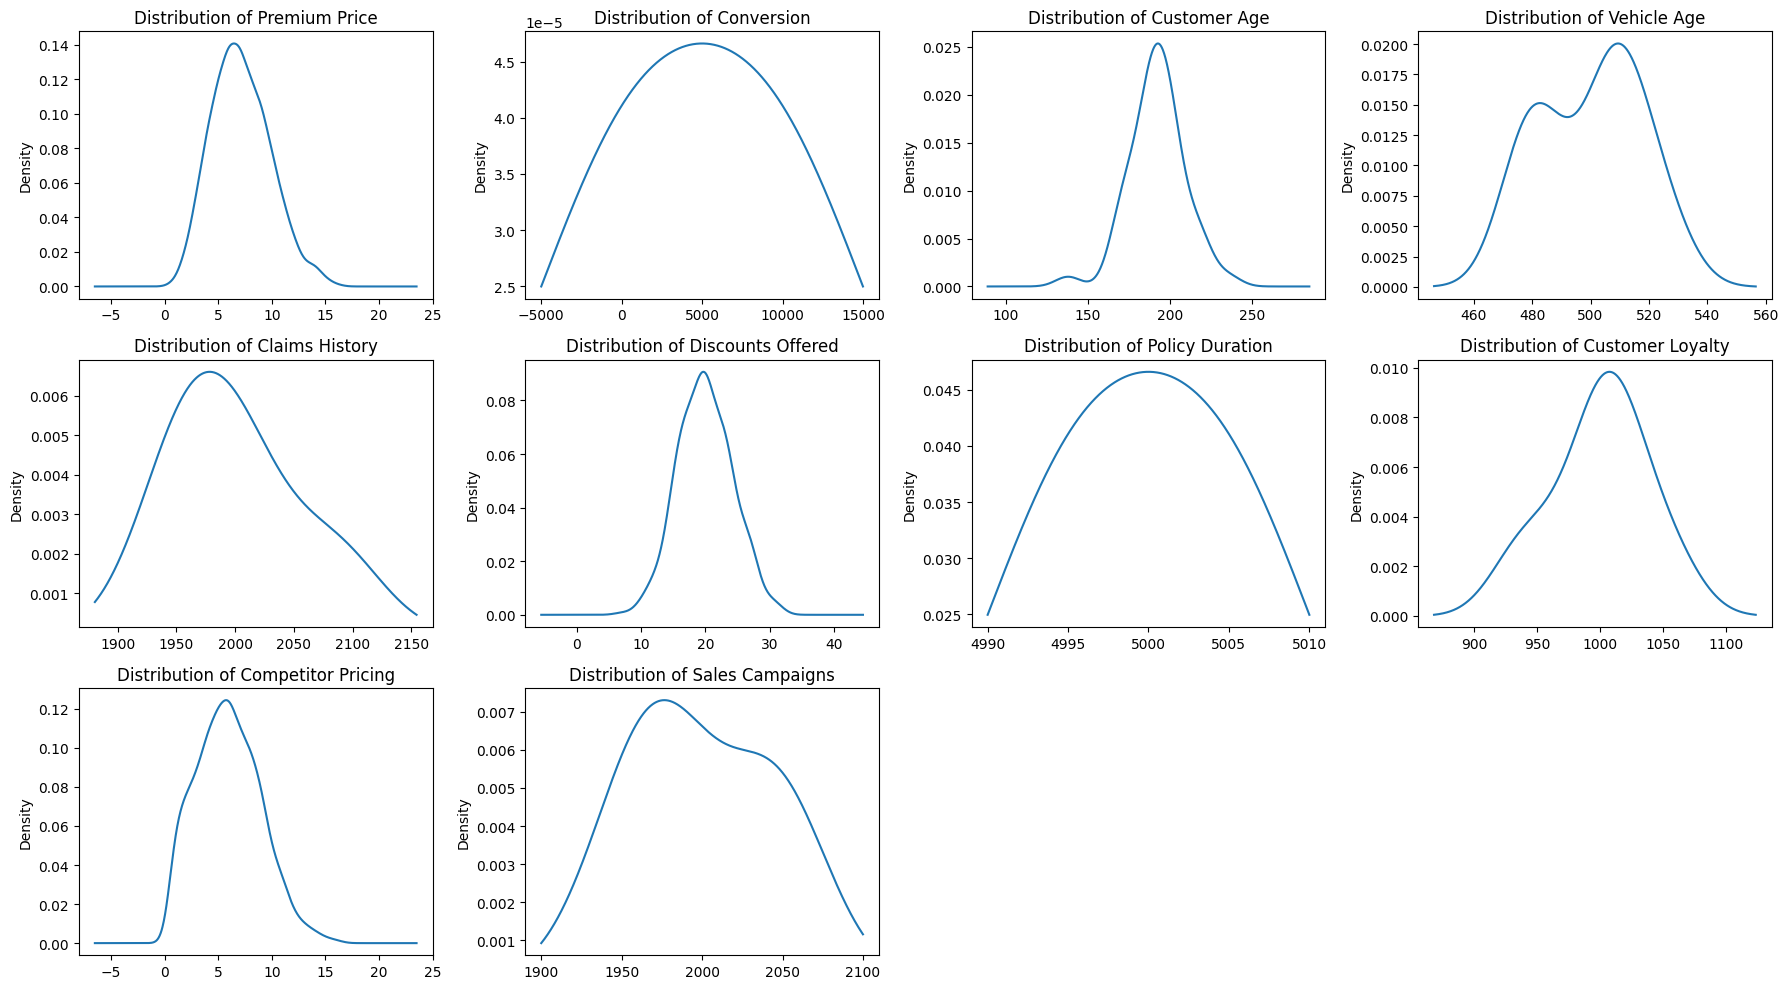

In [9]:
# lets make  kdeplot to understand the distribution nataure better
# lets make countplot for each numerical column
num_cols = [col for col in df.columns if df[col].dtype != "object"]
# lets make subplot for the graphs
fig,ax = plt.subplots(ncols=4, nrows=3, figsize=(18, 10))
ax = ax.flatten()

# loop over the columns 
for index, column in enumerate(num_cols):
    # make a countplot
    df[column].value_counts(ascending=False).plot(kind="kde", ax=ax[index])
    ax[index].set_title(f"Distribution of {column}")
    

# delete the unused subplots
for i in range(len(num_cols), len(ax)):
    fig.delaxes(ax[i])
    
plt.tight_layout()
plt.show()

In [10]:
def best_distribution_for_column(df: pd.DataFrame, column: str):
    # Convert the values into a numpy array, dropping NaN values
    values = df[column].dropna().values
    
    # Create Fitter instance and fit
    f = Fitter(values,
               distributions=['gamma',
                              'lognorm',
                              'beta',
                              'burr',
                              'norm',
                              'poisson',  # Corrected spelling
                              'binomial',
                              'bernoulli'])
    
    try:
        # Fit the variable
        f.fit()
        
        # Identify the best distribution
        best_fit = f.get_best()
        
        return best_fit
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

# Example test
best_fit_result = best_distribution_for_column(df, "Conversion")
print(best_fit_result)

{'norm': {'loc': 0.0003, 'scale': 0.017317909804592472}}


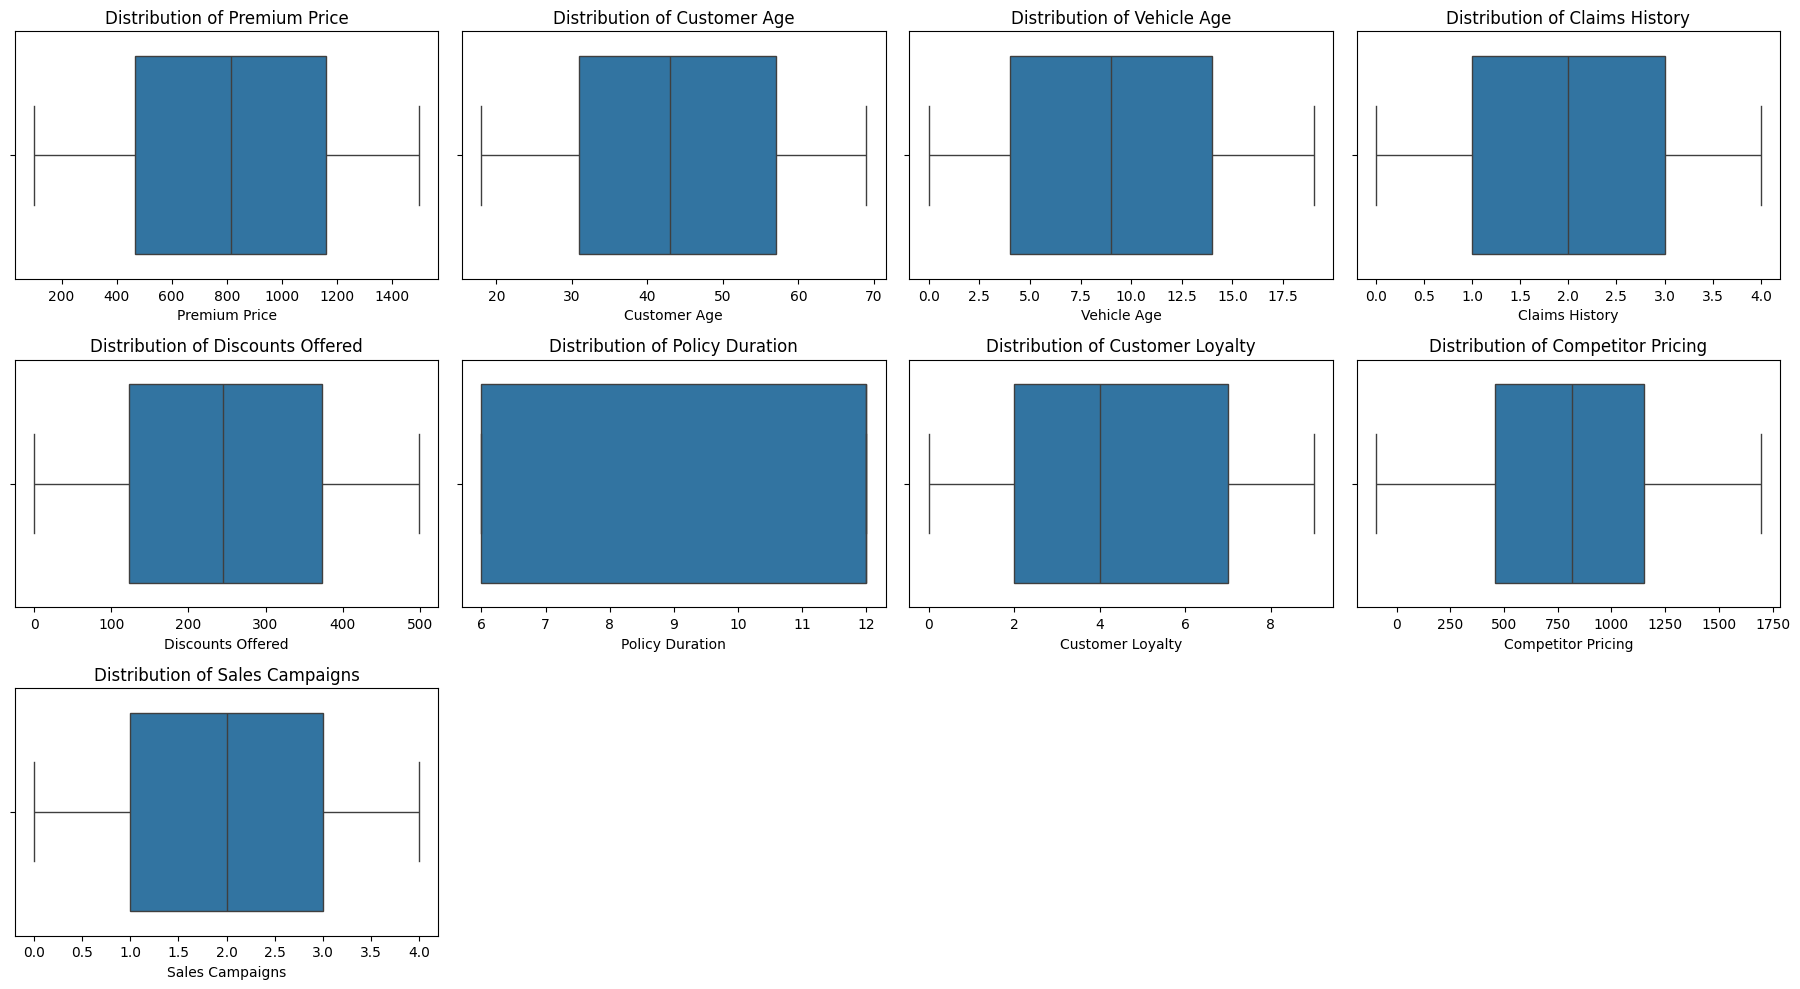

In [11]:
# lets make a boxplot to check if there are potential errors
num_cols = [col for col in df.columns if df[col].dtype != "object" and col != "Conversion"]
# lets make subplot for the graphs
fig,ax = plt.subplots(ncols=4, nrows=3, figsize=(18, 10))
ax = ax.flatten()

# loop over the columns 
for index, column in enumerate(num_cols):
    # make a countplot
    sns.boxplot(data=df, x=column, ax=ax[index])
    ax[index].set_title(f"Distribution of {column}")
    

# delete the unused subplots
for i in range(len(num_cols), len(ax)):
    fig.delaxes(ax[i])
    
plt.tight_layout()
plt.show()

* no outlier and no skewness found

In [12]:
df.columns

Index(['Premium Price', 'Conversion', 'Customer Age', 'Customer Gender',
       'Location', 'Vehicle Make', 'Vehicle Age', 'Coverage Type',
       'Claims History', 'Discounts Offered', 'Policy Duration',
       'Customer Loyalty', 'Marketing Channel', 'Competitor Pricing',
       'Sales Campaigns'],
      dtype='object')

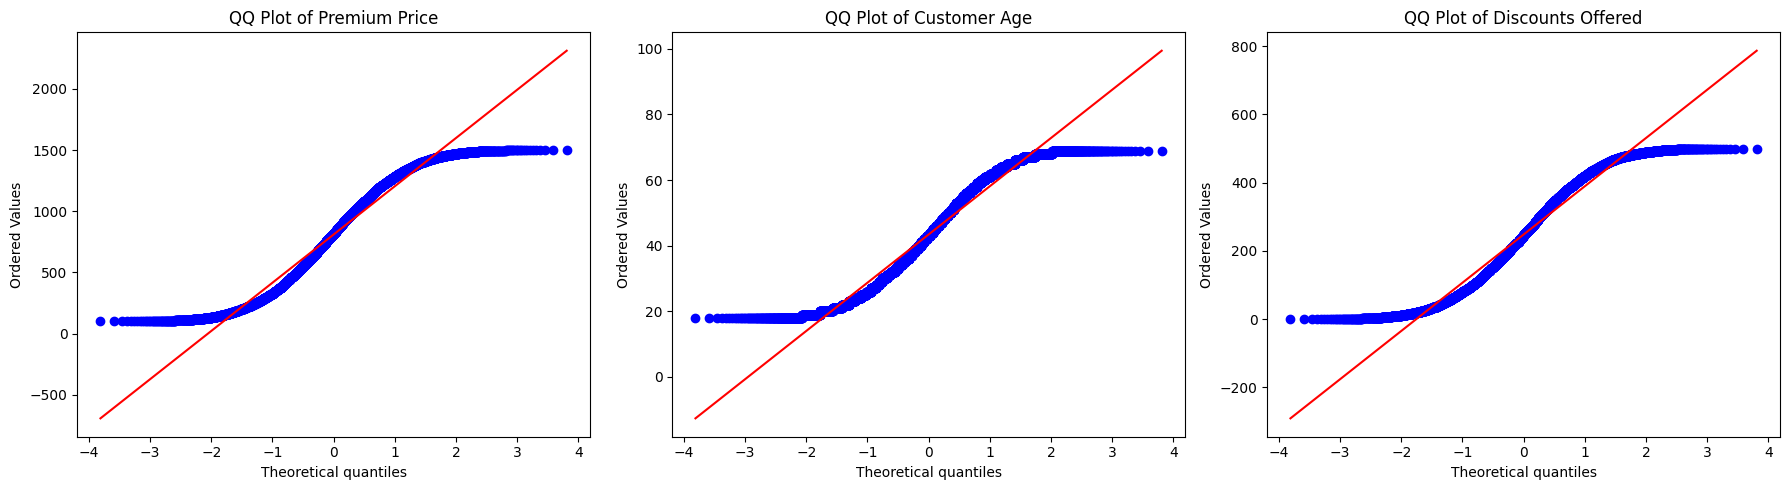

In [13]:
# since customer age, premium price and discount offered seems kinda like normal lets see how much normal they really are
norm_cols = ["Premium Price", "Customer Age", "Discounts Offered"]
# Create subplots for the graphs
fig, ax = plt.subplots(ncols=len(norm_cols), nrows=1, figsize=(18, 5))
ax = ax.flatten()

# Loop over the columns
for index, column in enumerate(norm_cols):
    if column in df.columns:  # Check if the column exists in the DataFrame
        # Check if the column is numeric
            # Make a QQ plot
            stats.probplot(df[column], dist="norm", plot=ax[index])
            ax[index].set_title(f"QQ Plot of {column}")
    else:
        print(f"Column '{column}' does not exist in the DataFrame.")

plt.tight_layout()
plt.show()

* they are not normally distributed.

### Bi-Variate Analysis

In [14]:
df["Conversion"].value_counts()

Conversion
0.0    9997
1.0       3
Name: count, dtype: int64

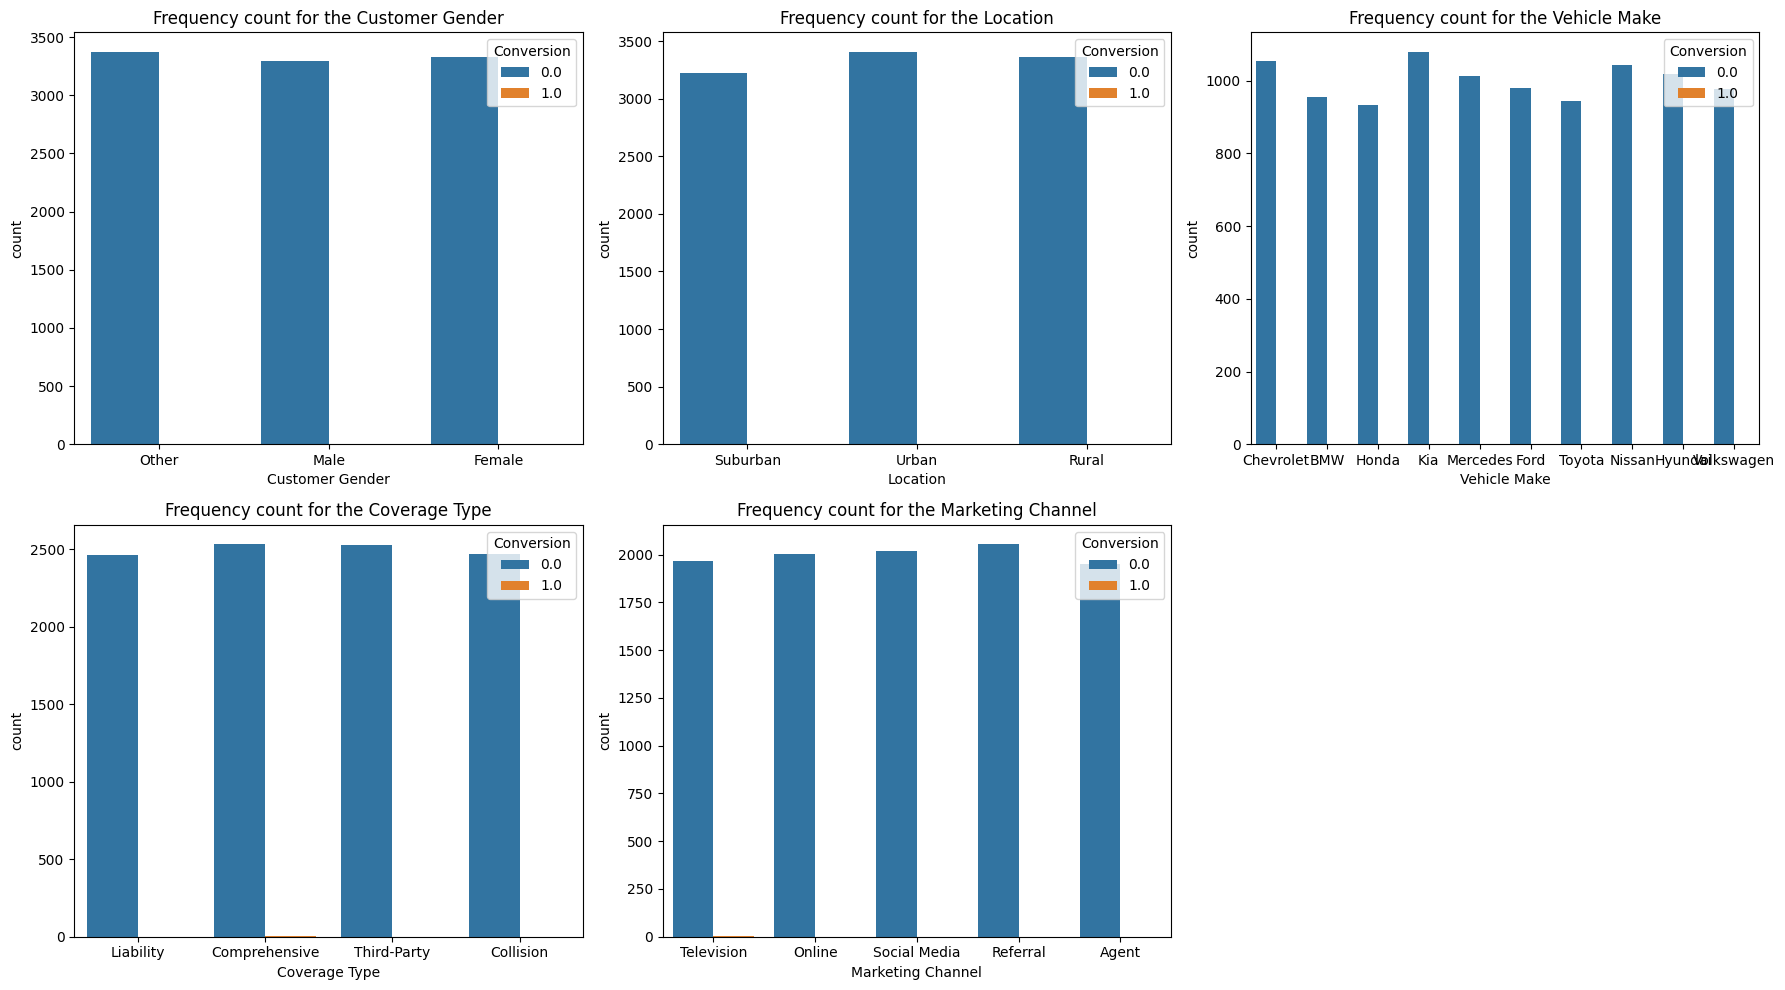

In [15]:
# Lets plot barplot against conversion rates against categorical columns
# lets make countplot for each categorical column
cat_cols = [col for col in df.columns if df[col].dtype == "object"]
# lets make subplot for the graphs
fig,ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))
ax = ax.flatten()

# loop over the columns 
for index, column in enumerate(cat_cols):
    # make a countplot
    sns.countplot(data=df, x=column, hue="Conversion", ax=ax[index])
    ax[index].set_title(f"Frequency count for the {column}")
    

# delete the unused subplots
for i in range(len(cat_cols), len(ax)):
    fig.delaxes(ax[i])
    
plt.tight_layout()
plt.show()

* This shows that conversion rate is very less.

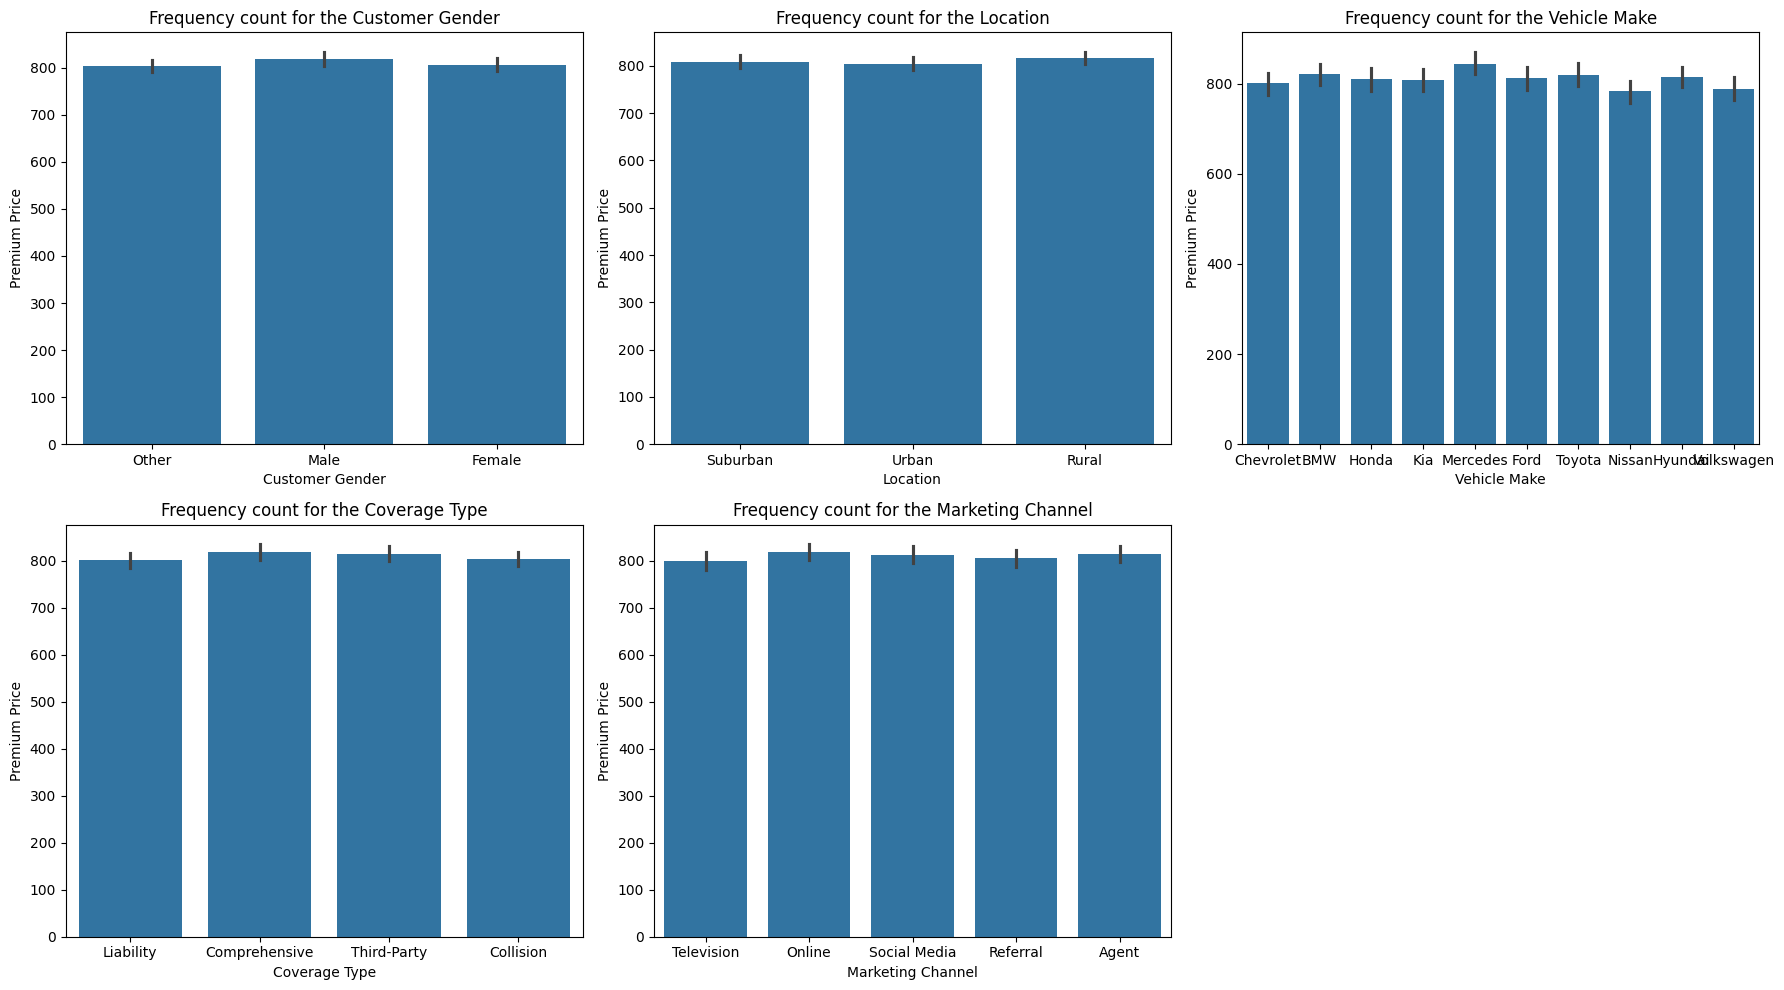

In [16]:
# lets plot premium price against categories to check on average which has more premium
# lets make countplot for each categorical column
cat_cols = [col for col in df.columns if df[col].dtype == "object"]
# lets make subplot for the graphs
fig,ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 10))
ax = ax.flatten()

# loop over the columns 
for index, column in enumerate(cat_cols):
    # make a countplot
    sns.barplot(data=df, x=column, y="Premium Price", ax=ax[index])
    ax[index].set_title(f"Frequency count for the {column}")
    

# delete the unused subplots
for i in range(len(cat_cols), len(ax)):
    fig.delaxes(ax[i])
    
plt.tight_layout()
plt.show()

* Male, Rural, Mercedes, Comprehensive and online premium are expensive on average slightly.

In [17]:
df.columns

Index(['Premium Price', 'Conversion', 'Customer Age', 'Customer Gender',
       'Location', 'Vehicle Make', 'Vehicle Age', 'Coverage Type',
       'Claims History', 'Discounts Offered', 'Policy Duration',
       'Customer Loyalty', 'Marketing Channel', 'Competitor Pricing',
       'Sales Campaigns'],
      dtype='object')

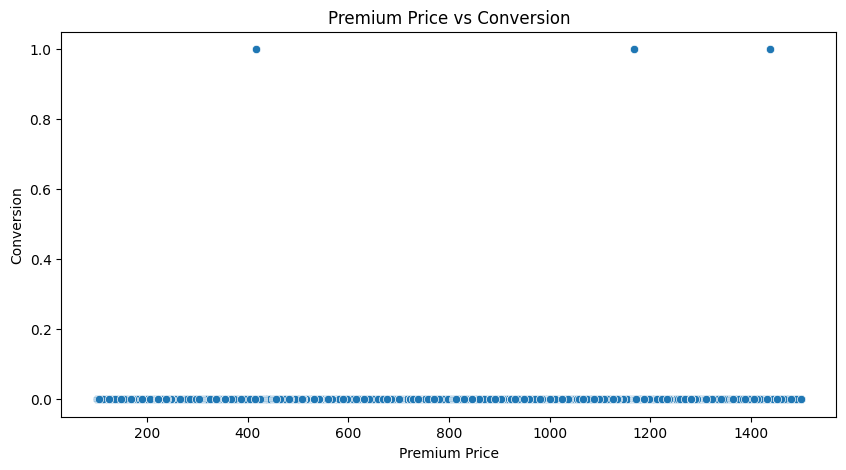

In [18]:
# lets see the relationship b/w converion rates and premium prices
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='Premium Price', y='Conversion')
plt.title('Premium Price vs Conversion')
plt.show()

- There is no relationship b/w them.

In [55]:
import pandas as pd

def calculate_elasticity(group, price_column):
    """
    This function calculates the price elasticity of demand based on changes 
    in price (Premium Price) and conversion rate (Conversion).
    """
    price_change = group[price_column].pct_change()
    conversion_rate_change = group["Conversion"].pct_change()
    
    # Avoid division by zero or NaN issues
    elasticity = conversion_rate_change / price_change
    
    # Drop any NaN or infinite values caused by zero or missing changes
    elasticity = elasticity.replace([float('inf'), -float('inf')], float('nan')).dropna()
    
    return elasticity.mean()
# List to store results
result = []

# Apply elasticity calculation on all categorical columns
for column in cat_cols:
    elasticity_by_category = df.groupby(column).apply(calculate_elasticity, price_column="Premium Price")
    
    # Save the column name, category, and elasticity value in the result list
    for category, elasticity in elasticity_by_category.items():  # Use items() here
        result.append({
            'Category Column': column,
            'Category Value': category,
            'Elasticity': elasticity
        })

# Convert the result list into a DataFrame
elasticity_df = pd.DataFrame(result)

# Drop rows with NaN values in Elasticity
cleaned_elasticity_df = elasticity_df.dropna(subset=['Elasticity'])

# Show the cleaned DataFrame
print(cleaned_elasticity_df)


      Category Column Category Value  Elasticity
0     Customer Gender         Female    3.243792
1     Customer Gender           Male    7.291267
3            Location          Rural    7.684492
5            Location          Urban    6.000572
10       Vehicle Make        Hyundai    2.244231
11       Vehicle Make            Kia    2.716446
12       Vehicle Make       Mercedes   -1.358306
17      Coverage Type  Comprehensive    2.480338
18      Coverage Type      Liability   -0.575967
21  Marketing Channel         Online   -0.547244
24  Marketing Channel     Television    3.585322


### Elasticity Explanation:

- Greater than 1: Demand is elastic (high sensitivity to price).
- Equal to 1: Demand is unit elastic (proportional sensitivity).
- Less than 1: Demand is inelastic (low sensitivity to price).

**If you see values greater than 1, you might consider lowering prices to boost conversions, while if they’re less than 1, you might have room to increase prices without significantly impacting sales.**
* so the negative values indicating that we can increase the prices of premium in this category while positive one suggest they should be reduce in order to increase the conversion rate.

In [20]:
df.head()

,Premium Price,Conversion,Customer Age,Customer Gender,Location,Vehicle Make,Vehicle Age,Coverage Type,Claims History,Discounts Offered,Policy Duration,Customer Loyalty,Marketing Channel,Competitor Pricing,Sales Campaigns
0,1226,0.0,60,Other,Suburban,Chevrolet,17,Liability,0,303,12,0,Television,1281,4
1,960,0.0,46,Other,Urban,BMW,11,Comprehensive,2,161,12,7,Online,917,3
2,1394,0.0,67,Male,Urban,Honda,2,Third-Party,4,212,12,5,Social Media,1476,2
3,1230,0.0,19,Other,Rural,BMW,16,Third-Party,0,483,12,5,Social Media,1202,3
4,1195,0.0,26,Other,Urban,Chevrolet,13,Liability,1,91,6,9,Social Media,1382,2


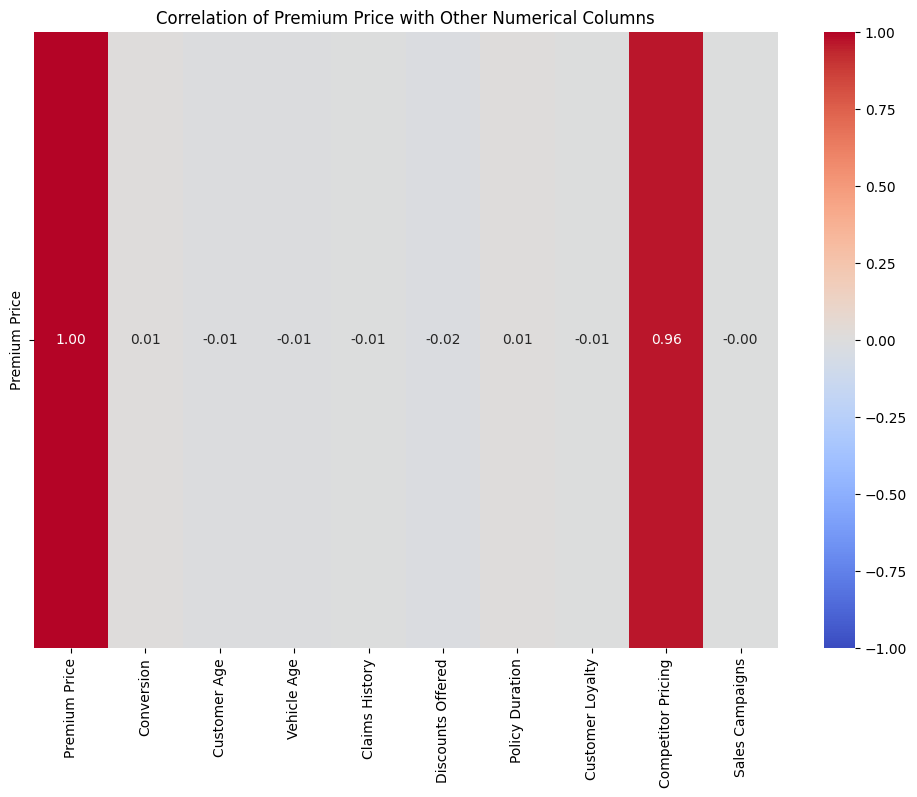

In [21]:
# lets make a correaltion graph (heatmap) to check price relationship with other columns
# select all numerical columns
numeric_cols = df.select_dtypes(include=["int", "float"]).columns
# calculate the correlation matrix for all columns
corr_matrix = df[numeric_cols].corr()
# correlation of premium price with other
premium_price_corr = corr_matrix["Premium Price"].sort_values(ascending=False)

plt.figure(figsize=(12, 8))

# Create a heatmap for the correlations with 'Premium Price'
sns.heatmap(corr_matrix.loc[["Premium Price"], numeric_cols], 
            cmap='coolwarm', 
            cbar=True, 
            annot=True, 
            fmt=".2f", 
            vmin=-1, 
            vmax=1)

# Set title and show the plot
plt.title('Correlation of Premium Price with Other Numerical Columns')
plt.show()

- Highly Correlated with the competitor prices.

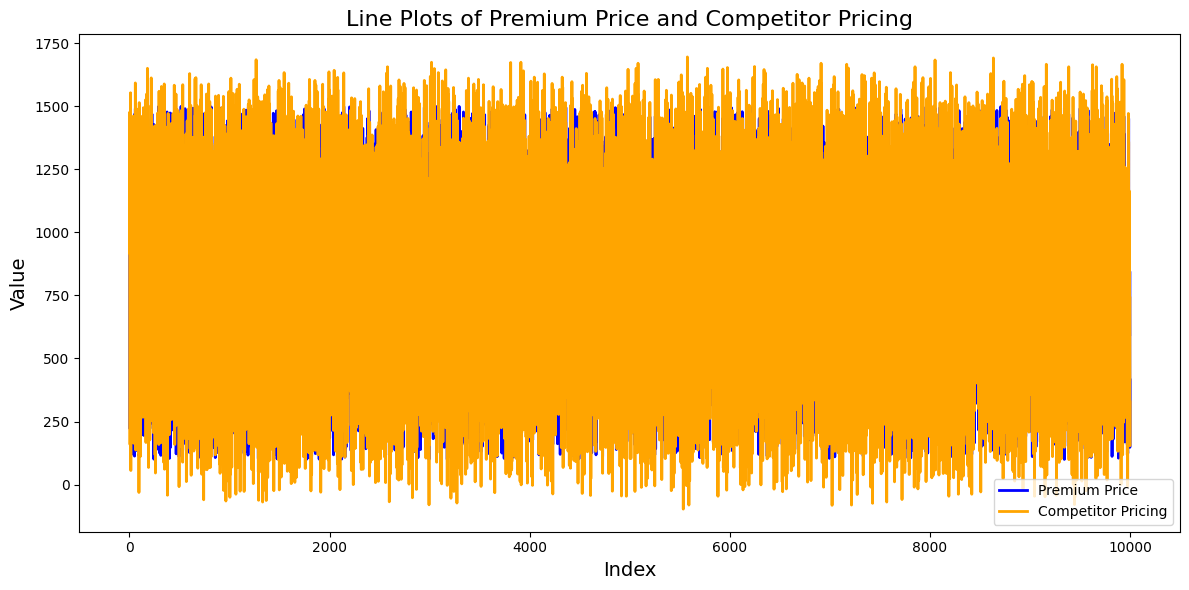

In [22]:
# make a line plot b/w premium price and competitor price to see how they changes w.r.t each other
# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the first line: Premium Price
ax.plot(df['Premium Price'], label='Premium Price', color='blue', linewidth=2)
# Plot the second line: Competitor Pricing
ax.plot(df['Competitor Pricing'], label='Competitor Pricing', color='orange', linewidth=2)
# Adding titles and labels
ax.set_title('Line Plots of Premium Price and Competitor Pricing', fontsize=16)
ax.set_xlabel('Index', fontsize=14)
ax.set_ylabel('Value', fontsize=14)

# Show legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

* competitor prices overlays our prices completely indicating there prices are always greater then our.

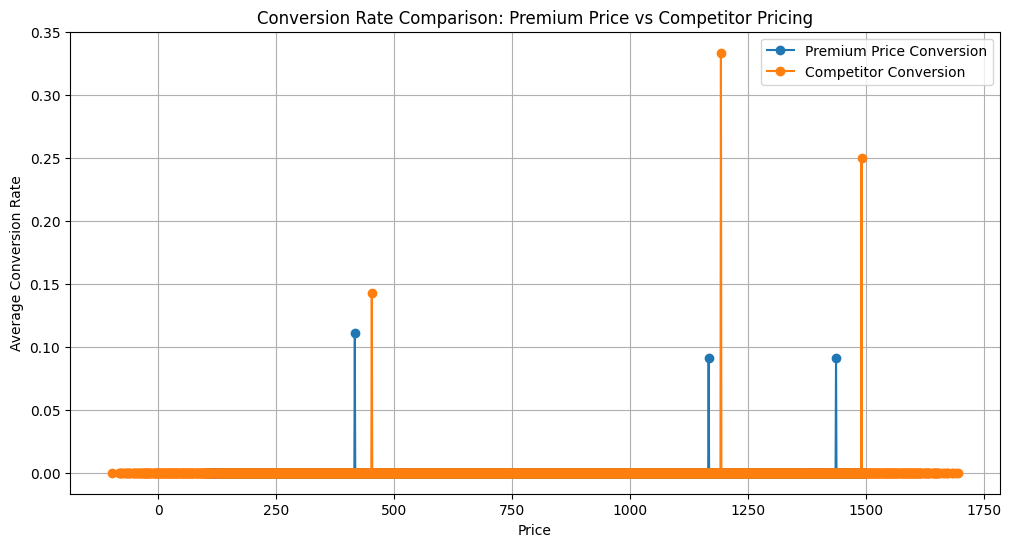

In [24]:
# Calculate average conversion rates by Premium Price
avg_premium_conversion = df.groupby('Premium Price')['Conversion'].mean().reset_index()

# Calculate average conversion rates by Competitor Pricing
avg_competitor_conversion = df.groupby('Competitor Pricing')['Conversion'].mean().reset_index()

# Merge results for comparison
comparison_df = pd.merge(avg_premium_conversion, avg_competitor_conversion, 
                          left_on='Premium Price', right_on='Competitor Pricing', 
                          how='outer', suffixes=('_Premium', '_Competitor'))

# Visualizing the average conversion rates
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Premium Price'], comparison_df['Conversion_Premium'], label='Premium Price Conversion', marker='o')
plt.plot(comparison_df['Competitor Pricing'], comparison_df['Conversion_Competitor'], label='Competitor Conversion', marker='o')
plt.title('Conversion Rate Comparison: Premium Price vs Competitor Pricing')
plt.xlabel('Price')
plt.ylabel('Average Conversion Rate')
plt.legend()
plt.grid()
plt.show()

- Indicating that our competitors prices is higher and there conversion rate are also high might be some other issue for such low conversion for us.

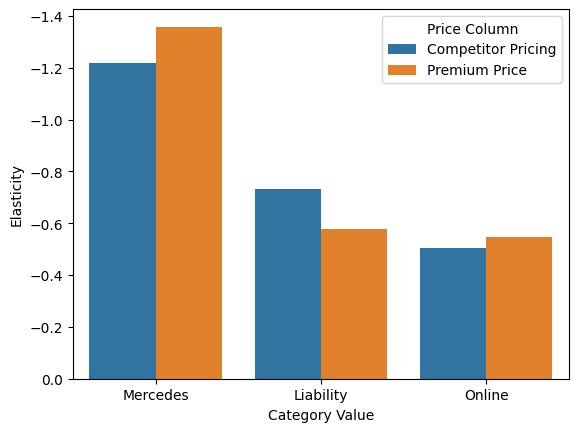

In [57]:
#lets check at which cateogry over premium and competitor has potential for price increment so we can do it asap
# Apply elasticity calculation on all categorical columns for both price columns
price_columns = ["Competitor Pricing", "Premium Price"]
for column in cat_cols:
    for price_column in price_columns:
        elasticity_by_category = df.groupby(column).apply(calculate_elasticity, price_column=price_column)
        
        # Save the column name, category, price column, and elasticity value in the result list
        for category, elasticity in elasticity_by_category.items():
            result.append({
                'Category Column': column,
                'Category Value': category,
                'Price Column': price_column,
                'Elasticity': elasticity
            })

# Convert the result list into a DataFrame
elasticity_df = pd.DataFrame(result)

# Drop rows with NaN values in Elasticity
cleaned_elasticity_df = elasticity_df.dropna(subset=['Elasticity'])

# calculate where is the area for the increments
potential_increments = cleaned_elasticity_df[cleaned_elasticity_df["Elasticity"] < 0].dropna()
# Plot the barplot with negative elasticity
sns.barplot(data=potential_increments, x="Category Value", y="Elasticity", hue="Price Column")

# Invert the y-axis
plt.gca().invert_yaxis()
plt.show()

- All three segments show potential for a price increase, with Mercedes having the most potential.
- Competitors have more potential than us, but we can dominate in the liability area if we adjust pricing strategically.

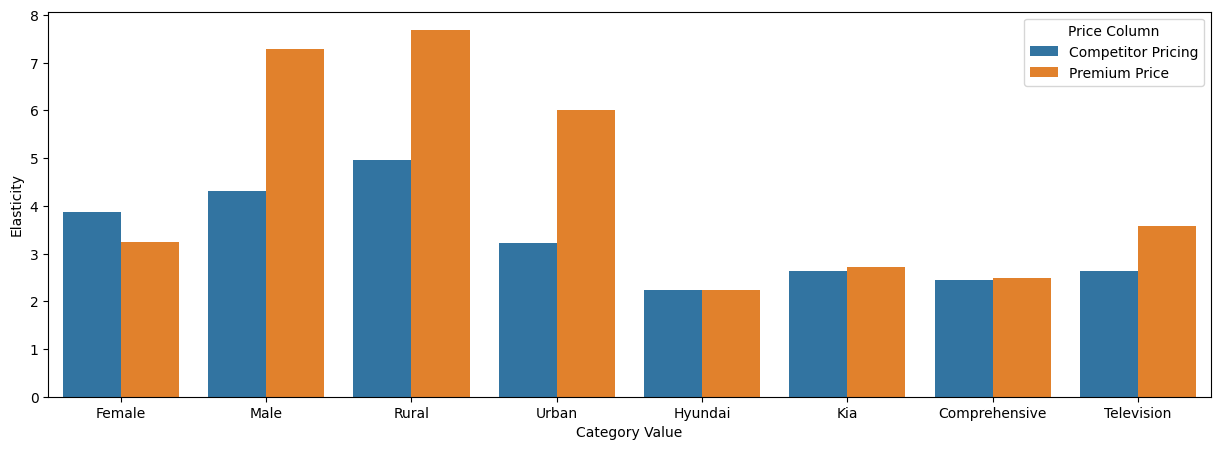

In [69]:
# make a figure size
plt.figure(figsize=(15,5))
# Now lets see at which areas we need to drop pric
potential_decrements = cleaned_elasticity_df[cleaned_elasticity_df["Elasticity"] > 0]
# Plot the barplot with positive elasticity
sns.barplot(data=potential_decrements, x="Category Value", y="Elasticity", hue="Price Column")

plt.show()

- Competitor prices for males, rural areas, and television are significantly higher than ours, showing potential to match their pricing.
- Our prices are higher for females, but we are still performing well in this segment.

**This indicates areas where we could raise prices to match competitors while maintaining a good position in the market.**

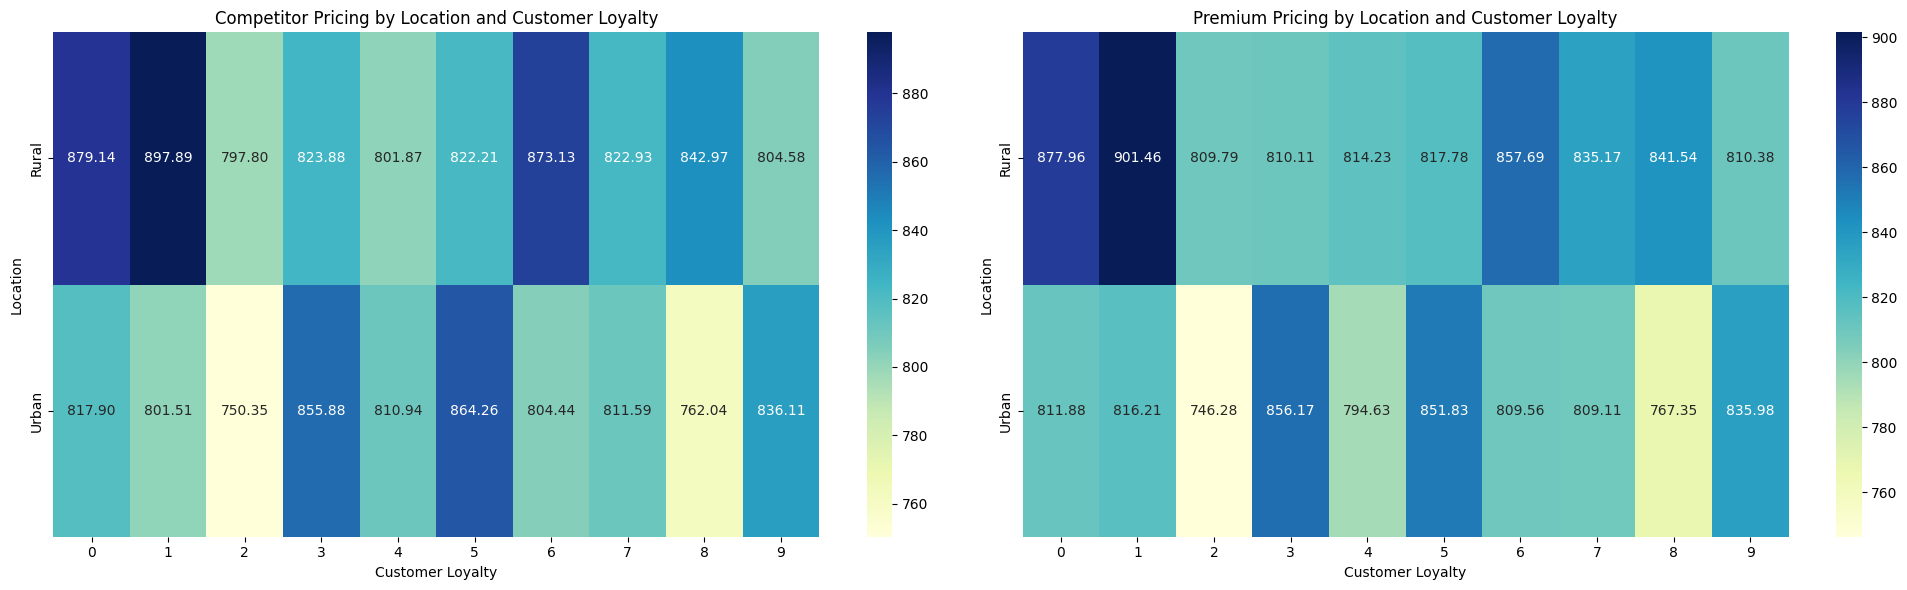

In [89]:
# lets check the areas where there is potential to increase the prices how loyal customers are to competitor in it.
selected_rows = df[(df['Customer Gender'] == 'Male') & 
                   (df['Location'].isin(['Rural', 'Urban']))]

# Create pivot tables for competitor and premium pricing
competitor_pivot = selected_rows.pivot_table(
    index='Location', 
    columns='Customer Loyalty', 
    values='Competitor Pricing', 
    aggfunc='mean'
)

premium_pivot = selected_rows.pivot_table(
    index='Location', 
    columns='Customer Loyalty', 
    values='Premium Price', 
    aggfunc='mean'
)

# Set up the matplotlib figure with 1 row and 2 columns
plt.figure(figsize=(20, 6))

# First subplot for Competitor Pricing
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
sns.heatmap(competitor_pivot, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True)
plt.title('Competitor Pricing by Location and Customer Loyalty')
plt.xlabel('Customer Loyalty')
plt.ylabel('Location')

# Second subplot for Premium Pricing
plt.subplot(1, 2, 2)
sns.heatmap(premium_pivot, annot=True, cmap='YlGnBu', fmt=".2f", cbar=True)
plt.title('Premium Pricing by Location and Customer Loyalty')
plt.xlabel('Customer Loyalty')
plt.ylabel('Location')

# Adjust layout
plt.tight_layout()
plt.show()

**It seems like you're providing specific price increment recommendations for different customer loyalty scores in urban and rural areas. Here's a clearer way to present that information:**

#### Suggested Price Increments
1. Urban Area
- Loyalty Score 5: Increase by $7
- Loyalty Score 6: Increase by $5
- Loyalty Score 9: Increase by $1
2. Rural Area
- Loyalty Score 9: Increase by $6
- Loyalty Score 7: Increase by $13
- Loyalty Score 6: Increase by $16
- Loyalty Score 5: Increase by $5
- Loyalty Score 4: Increase by $13

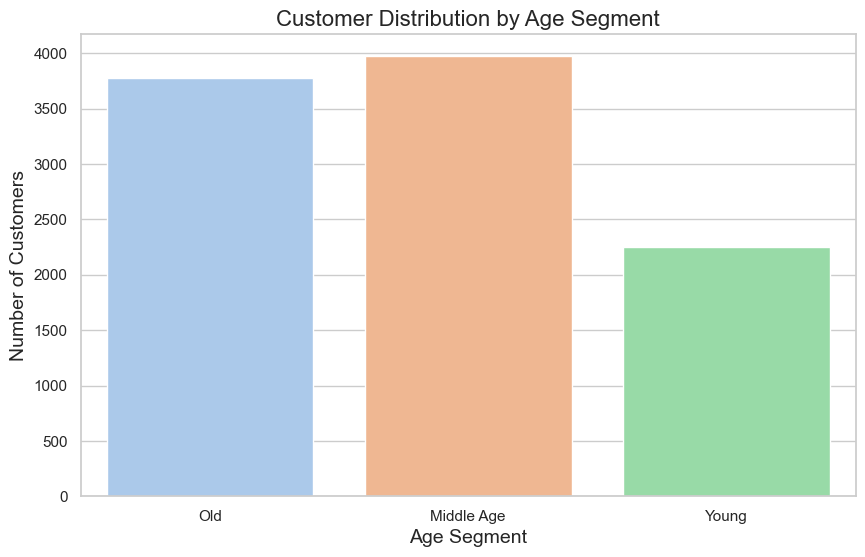

In [102]:
# lets see which specific age group people our customer is targeting so we also target them
# Define a function to categorize age groups
def categorize_age(age):
    if 18 <= age <= 29:
        return 'Young'
    elif 30 <= age <= 49:
        return 'Middle Age'
    elif 50 <= age <= 69:
        return 'Old'
    else:
        return 'Unknown'  # For ages outside the specified range

# 'Customer Age' is the column with age data
df['Age Segment'] = df['Customer Age'].apply(categorize_age)

# Set the visual style of seaborn
sns.set(style="whitegrid")

# Count plot to visualize the distribution of customers across age segments
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Age Segment', palette='pastel')

# Adding titles and labels
plt.title('Customer Distribution by Age Segment', fontsize=16)
plt.xlabel('Age Segment', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)

# Display the plot
plt.show()

- Seems Like Competitors are more targeting Middle Age and old.
#### Reasons
1. Financial Stability: Both demographics often have higher disposable incomes, making them more likely to spend on quality products and services.

2. Specific Needs: They have unique needs related to health, lifestyle, and family that can be effectively addressed with tailored offerings.

3. Brand Loyalty: These age groups tend to be more brand-loyal, which can lead to repeat purchases and long-term customer relationships.

4. Influence on Family Purchases: They often influence family spending decisions, impacting the purchasing behavior of younger generations.

5. Market Size: With an aging population, targeting these segments allows businesses to tap into a growing market segment with significant purchasing power.

<Axes: xlabel='Marketing Channel', ylabel='Competitor Pricing'>

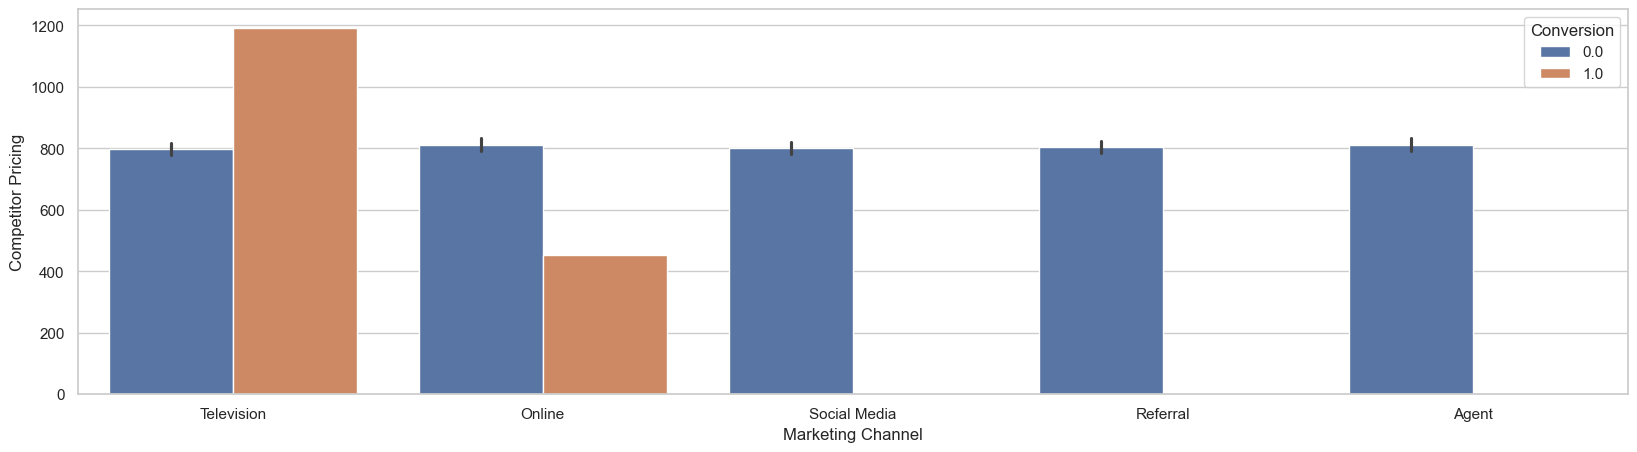

In [110]:
# lets see on which marketing channel then conversion rate is high for them
aged_customers = df[df["Age Segment"].isin(["Middle Age", "Old"])]
# make a barplot for them
plt.figure(figsize=(20,5))
sns.barplot(data=aged_customers, x="Marketing Channel", y="Competitor Pricing", hue="Conversion")

- Most of the conversion is at television where customer prices were almost 1200$ on average and second is at online but it is quite low with price on avg 450$.